Idea: Extend LTH to feature selection - Pruning + gradient descent for feature selection

Result:

With 70% of features remaining, we are able to get better accuracy and training time

The red pixels are the features that are ignored in the final feature subset

And this feature subset extends across neural networks. One important limitation of the original LTH paper is that it only works with same random weights. Literature later identified supermasks that, when applied to new random weights, do better than random, but is not nearly comparable to original performance. 

By applying the same pruning technique to feature selection, however, we find that unlike LTH for NN parameters, the feature subset is elastic, i.e., it is able to extend even to new random weights

These results are really promising

In [ ]:
import numpy as np
import torch

In [2]:
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader, sampler
import torchvision.datasets as datasets
import torchvision.transforms as T
import torchvision.transforms.functional as F

dtype = torch.float32

In [3]:
batch_size = 64

mnist_train = datasets.MNIST('.', download = True, train = True, transform = T.ToTensor())
loader_train = DataLoader(mnist_train, batch_size=batch_size, sampler=sampler.SubsetRandomSampler(range(50000)))

mnist_val = datasets.MNIST('.', download = True, train = True, transform = T.ToTensor())
loader_val = DataLoader(mnist_val, batch_size=batch_size, sampler=sampler.SubsetRandomSampler(range(50000, 60000)))

torch.Size([64, 1, 28, 28])


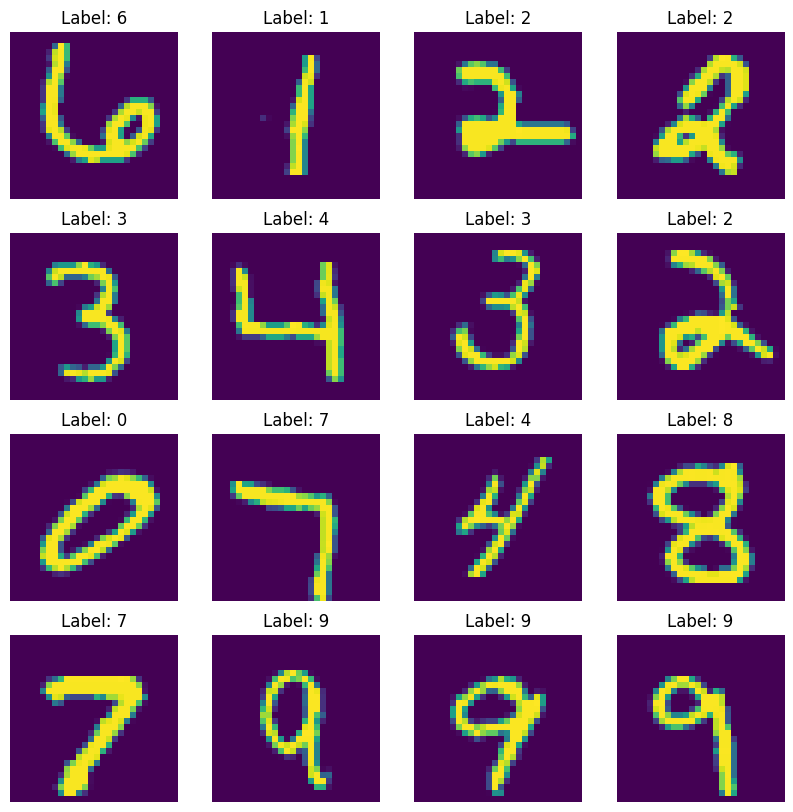

In [4]:
images, labels = next(iter(loader_train))

# Print the shape of the images and labels
print(images.shape)

# Plot the images
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].permute(1, 2, 0))
    ax.axis('off')
    ax.set_title(f"Label: {labels[i]}")

plt.show()


In [10]:
def two_layer_fc(x, params):
    x = x.view(-1, 28 * 28)
    w1, w2, mult = params

    x *= mult.view(1, -1)
    x = torch.relu(x @ w1)
    x = x @ w2
    
    return x

# Example usage:
dtype = torch.float
batch_size = 64  # Assuming a batch size is defined somewhere.

x = torch.zeros((batch_size, 28 * 28), dtype=dtype)
hidden_layer_size = 42

w1 = torch.zeros((28 * 28, hidden_layer_size), dtype=dtype, requires_grad=True)
w2 = torch.zeros((hidden_layer_size, 10), dtype=dtype, requires_grad=True)
mult = torch.zeros((28 * 28), dtype=dtype, requires_grad=True)

scores = two_layer_fc(x, [w1, w2, mult])
# Mult is a diagonal matrix

In [11]:
def random_weight(shape):
    if len(shape) == 2:
        fan_in = shape[0]
    else:
        fan_in = np.prod(shape[1:])
    
    w = torch.randn(shape, dtype=dtype) * np.sqrt(2. / fan_in)
    w.requires_grad = True
    
    return w

def zero_weight(shape):
    return torch.zeros(shape, dtype=dtype, requires_grad=True)

# create a weight of shape [3 x 5]
# you should see the type `torch.cuda.FloatTensor` if you use GPU.
# Otherwise it should be `torch.FloatTensor`
random_weight((3, 5))

tensor([[-1.4223,  0.2172,  0.1237,  0.8609,  0.3421],
        [-0.0722, -0.7307, -0.5596,  1.0378,  0.8202],
        [ 0.0192,  0.4795,  0.9285, -0.8563, -0.5411]], requires_grad=True)

In [12]:
def check_accuracy(loader, model_fn, params):
    split = 'val' if loader.dataset.train else 'test'
    print('Checking accuracy on the %s set' % split)
    num_correct, num_samples = 0, 0
    with torch.no_grad():
        for x, y in loader:
            scores = model_fn(x, params)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f%%)' % (num_correct, num_samples, 100 * acc))
        
        return acc

In [29]:
def train(model_fn, params, learning_rate, print_every=100):
    w1, w2, mult, m1, m2, m3 = params
    
    last_accuracy = 0   
    
    for t, (x, y) in enumerate(loader_train):
        
        with torch.no_grad():
            w1 *= m1
            w2 *= m2
            mult *= m3
            
        scores = model_fn(x, [w1, w2, mult])
        loss = torch.nn.functional.cross_entropy(scores, y)
        loss.backward()
        
        with torch.no_grad():
            
            w1 -= learning_rate * w1.grad
            w2 -= learning_rate * w2.grad
            mult -= learning_rate * mult.grad

            w1.grad.zero_()
            w2.grad.zero_()
            mult.grad.zero_()

        if t % print_every == 0:            
            print('Iteration %d, loss = %.4f' % (t, loss.item()))
            
            with torch.no_grad():
                w1 *= m1
                w2 *= m2
                mult *= m3
            
            last_accuracy = check_accuracy(loader_val, model_fn, [w1, w2, mult])
            print()
            
    return last_accuracy

Iteration 0, loss = 2.4799
Checking accuracy on the val set
Got 1173 / 10000 correct (11.73%)

Iteration 200, loss = 0.8540
Checking accuracy on the val set
Got 8409 / 10000 correct (84.09%)

Iteration 400, loss = 0.4603
Checking accuracy on the val set
Got 8706 / 10000 correct (87.06%)

Iteration 600, loss = 0.6002
Checking accuracy on the val set
Got 8862 / 10000 correct (88.62%)

Iteration 0, loss = 0.3437
Checking accuracy on the val set
Got 8936 / 10000 correct (89.36%)

Iteration 200, loss = 0.3605
Checking accuracy on the val set
Got 9003 / 10000 correct (90.03%)

Iteration 400, loss = 0.3631
Checking accuracy on the val set
Got 9050 / 10000 correct (90.50%)

Iteration 600, loss = 0.3605
Checking accuracy on the val set
Got 9076 / 10000 correct (90.76%)

--------------------------------------------------------------------------------------------------------------------------------
1 iteration of pruning done Remaining Features: 95.02551020408163 %
-------------------------------

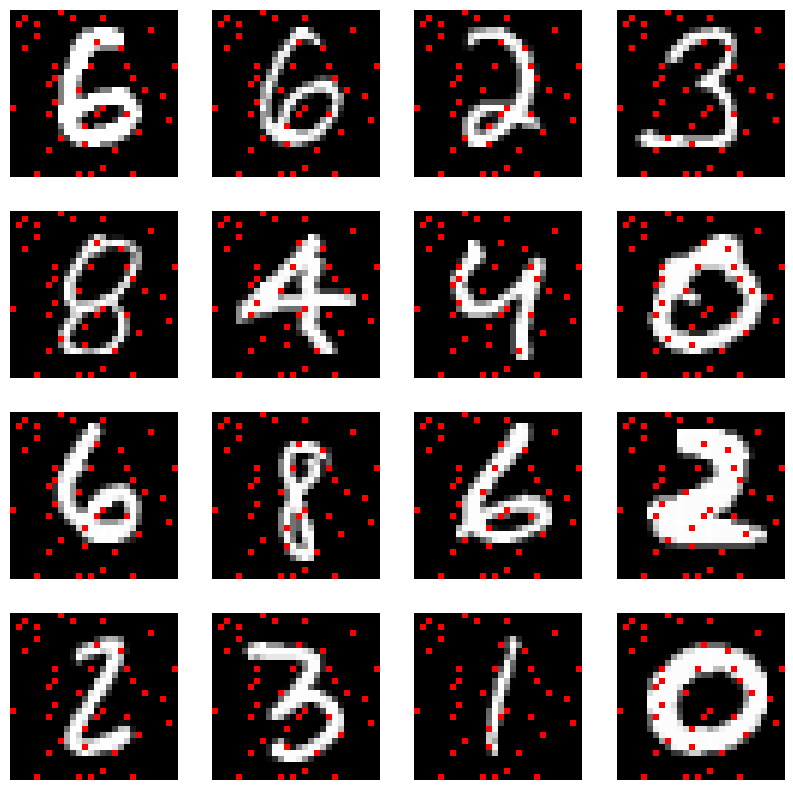

Iteration 0, loss = 2.5512
Checking accuracy on the val set
Got 1244 / 10000 correct (12.44%)

Iteration 200, loss = 0.8683
Checking accuracy on the val set
Got 8332 / 10000 correct (83.32%)

Iteration 400, loss = 0.4414
Checking accuracy on the val set
Got 8735 / 10000 correct (87.35%)

Iteration 600, loss = 0.6758
Checking accuracy on the val set
Got 8865 / 10000 correct (88.65%)

Iteration 0, loss = 0.4812
Checking accuracy on the val set
Got 8940 / 10000 correct (89.40%)

Iteration 200, loss = 0.3696
Checking accuracy on the val set
Got 8990 / 10000 correct (89.90%)

Iteration 400, loss = 0.3536
Checking accuracy on the val set
Got 9057 / 10000 correct (90.57%)

Iteration 600, loss = 0.3048
Checking accuracy on the val set
Got 9086 / 10000 correct (90.86%)

--------------------------------------------------------------------------------------------------------------------------------
2 iteration of pruning done Remaining Features: 90.3061224489796 %
--------------------------------

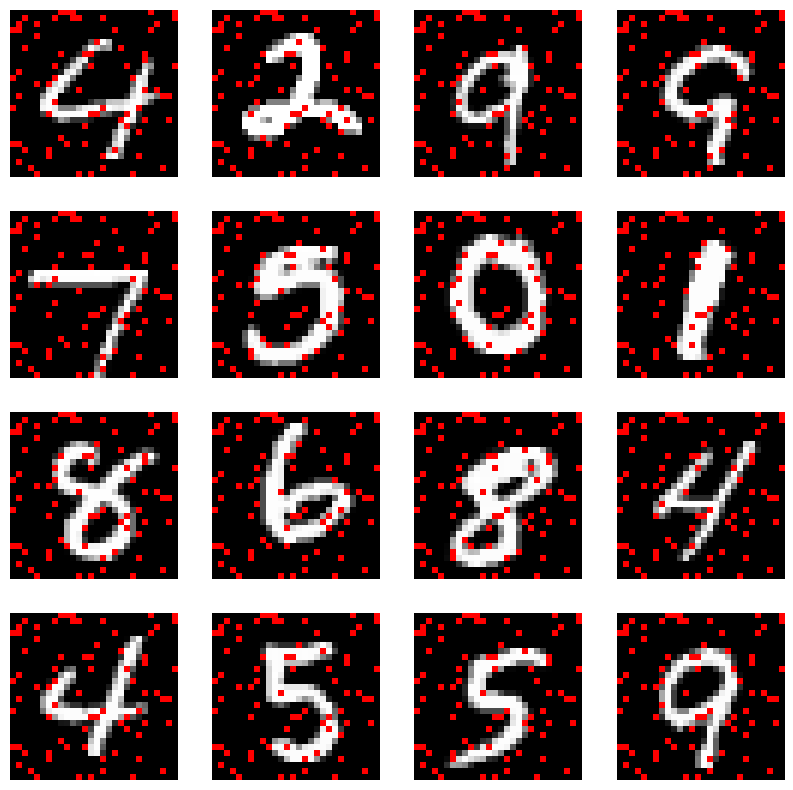

Iteration 0, loss = 2.5462
Checking accuracy on the val set
Got 1166 / 10000 correct (11.66%)

Iteration 200, loss = 0.8471
Checking accuracy on the val set
Got 8374 / 10000 correct (83.74%)

Iteration 400, loss = 0.4687
Checking accuracy on the val set
Got 8727 / 10000 correct (87.27%)

Iteration 600, loss = 0.4858
Checking accuracy on the val set
Got 8859 / 10000 correct (88.59%)

Iteration 0, loss = 0.4523
Checking accuracy on the val set
Got 8930 / 10000 correct (89.30%)

Iteration 200, loss = 0.3708
Checking accuracy on the val set
Got 9019 / 10000 correct (90.19%)

Iteration 400, loss = 0.3699
Checking accuracy on the val set
Got 9062 / 10000 correct (90.62%)

Iteration 600, loss = 0.4769
Checking accuracy on the val set
Got 9083 / 10000 correct (90.83%)

--------------------------------------------------------------------------------------------------------------------------------
3 iteration of pruning done Remaining Features: 85.84183673469389 %
-------------------------------

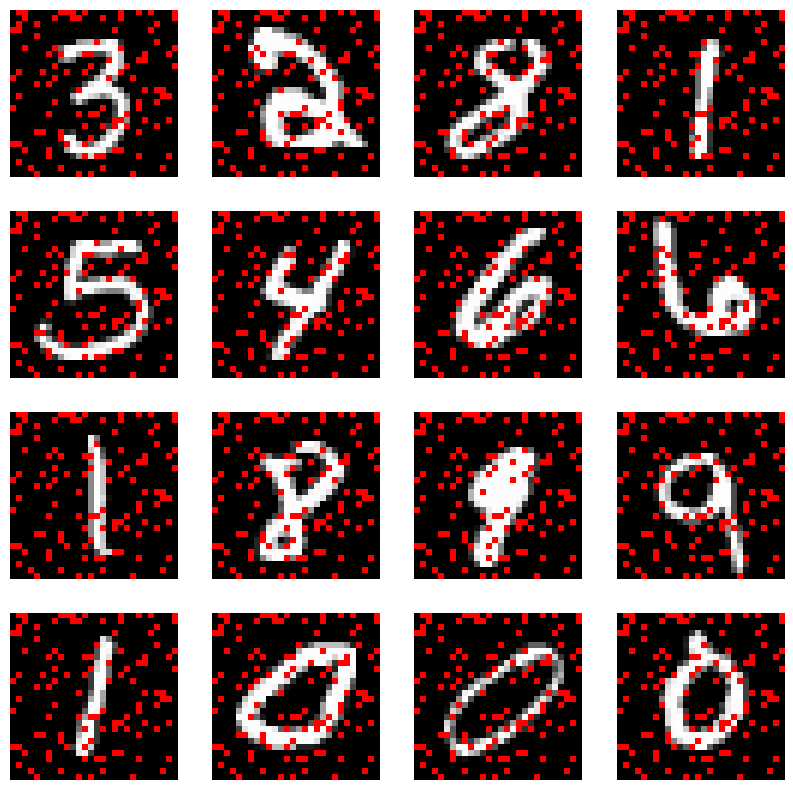

Iteration 0, loss = 2.5984
Checking accuracy on the val set
Got 1168 / 10000 correct (11.68%)

Iteration 200, loss = 0.7378
Checking accuracy on the val set
Got 8352 / 10000 correct (83.52%)

Iteration 400, loss = 0.7044
Checking accuracy on the val set
Got 8715 / 10000 correct (87.15%)

Iteration 600, loss = 0.3669
Checking accuracy on the val set
Got 8845 / 10000 correct (88.45%)

Iteration 0, loss = 0.4481
Checking accuracy on the val set
Got 8909 / 10000 correct (89.09%)

Iteration 200, loss = 0.2321
Checking accuracy on the val set
Got 9002 / 10000 correct (90.02%)

Iteration 400, loss = 0.4477
Checking accuracy on the val set
Got 9048 / 10000 correct (90.48%)

Iteration 600, loss = 0.4898
Checking accuracy on the val set
Got 9094 / 10000 correct (90.94%)

--------------------------------------------------------------------------------------------------------------------------------
4 iteration of pruning done Remaining Features: 81.63265306122449 %
-------------------------------

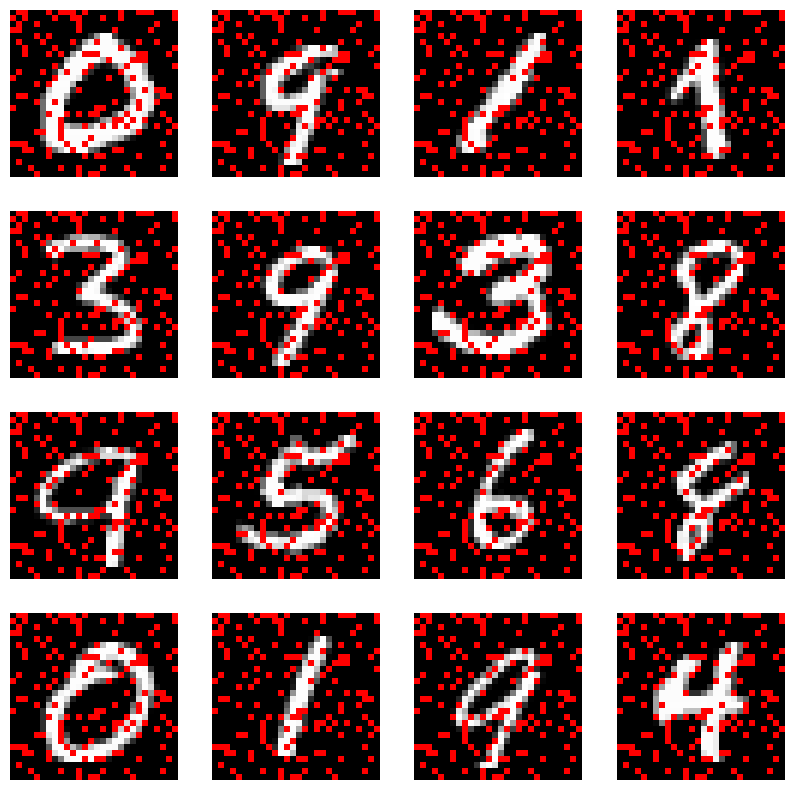

Iteration 0, loss = 2.5174
Checking accuracy on the val set
Got 1175 / 10000 correct (11.75%)

Iteration 200, loss = 0.6919
Checking accuracy on the val set
Got 8274 / 10000 correct (82.74%)

Iteration 400, loss = 0.4484
Checking accuracy on the val set
Got 8689 / 10000 correct (86.89%)

Iteration 600, loss = 0.6272
Checking accuracy on the val set
Got 8862 / 10000 correct (88.62%)

Iteration 0, loss = 0.3236
Checking accuracy on the val set
Got 8926 / 10000 correct (89.26%)

Iteration 200, loss = 0.5835
Checking accuracy on the val set
Got 9021 / 10000 correct (90.21%)

Iteration 400, loss = 0.3651
Checking accuracy on the val set
Got 9046 / 10000 correct (90.46%)

Iteration 600, loss = 0.3479
Checking accuracy on the val set
Got 9090 / 10000 correct (90.90%)

--------------------------------------------------------------------------------------------------------------------------------
5 iteration of pruning done Remaining Features: 77.55102040816327 %
-------------------------------

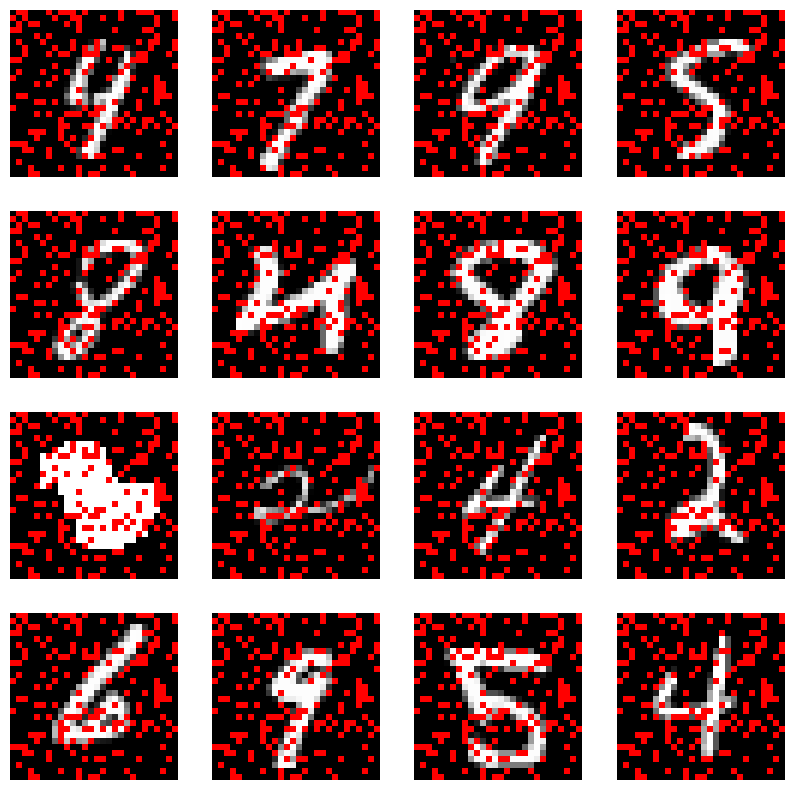

Iteration 0, loss = 2.5770
Checking accuracy on the val set
Got 1183 / 10000 correct (11.83%)

Iteration 200, loss = 0.7953
Checking accuracy on the val set
Got 8347 / 10000 correct (83.47%)

Iteration 400, loss = 0.4613
Checking accuracy on the val set
Got 8704 / 10000 correct (87.04%)

Iteration 600, loss = 0.4697
Checking accuracy on the val set
Got 8867 / 10000 correct (88.67%)

Iteration 0, loss = 0.3757
Checking accuracy on the val set
Got 8939 / 10000 correct (89.39%)

Iteration 200, loss = 0.3595
Checking accuracy on the val set
Got 8986 / 10000 correct (89.86%)

Iteration 400, loss = 0.3484
Checking accuracy on the val set
Got 9068 / 10000 correct (90.68%)

Iteration 600, loss = 0.2557
Checking accuracy on the val set
Got 9085 / 10000 correct (90.85%)

--------------------------------------------------------------------------------------------------------------------------------
6 iteration of pruning done Remaining Features: 73.72448979591837 %
-------------------------------

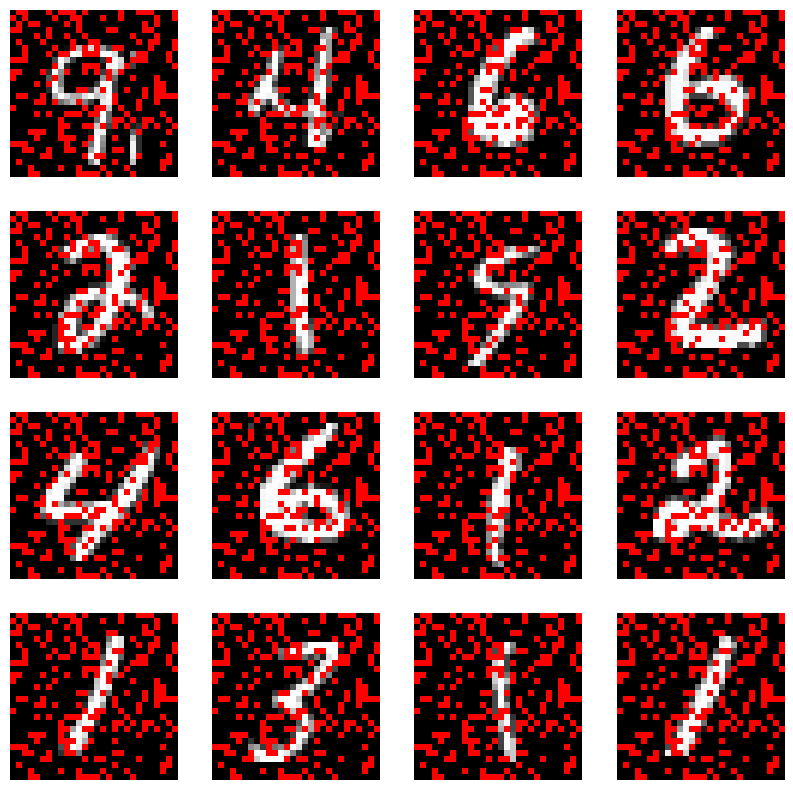

Iteration 0, loss = 2.4435
Checking accuracy on the val set
Got 1187 / 10000 correct (11.87%)

Iteration 200, loss = 0.8522
Checking accuracy on the val set
Got 8384 / 10000 correct (83.84%)

Iteration 400, loss = 0.5286
Checking accuracy on the val set
Got 8712 / 10000 correct (87.12%)

Iteration 600, loss = 0.9102
Checking accuracy on the val set
Got 8844 / 10000 correct (88.44%)

Iteration 0, loss = 0.5321
Checking accuracy on the val set
Got 8923 / 10000 correct (89.23%)

Iteration 200, loss = 0.4073
Checking accuracy on the val set
Got 8992 / 10000 correct (89.92%)

Iteration 400, loss = 0.3675
Checking accuracy on the val set
Got 9065 / 10000 correct (90.65%)

Iteration 600, loss = 0.5478
Checking accuracy on the val set
Got 9095 / 10000 correct (90.95%)

--------------------------------------------------------------------------------------------------------------------------------
7 iteration of pruning done Remaining Features: 70.15306122448979 %
-------------------------------

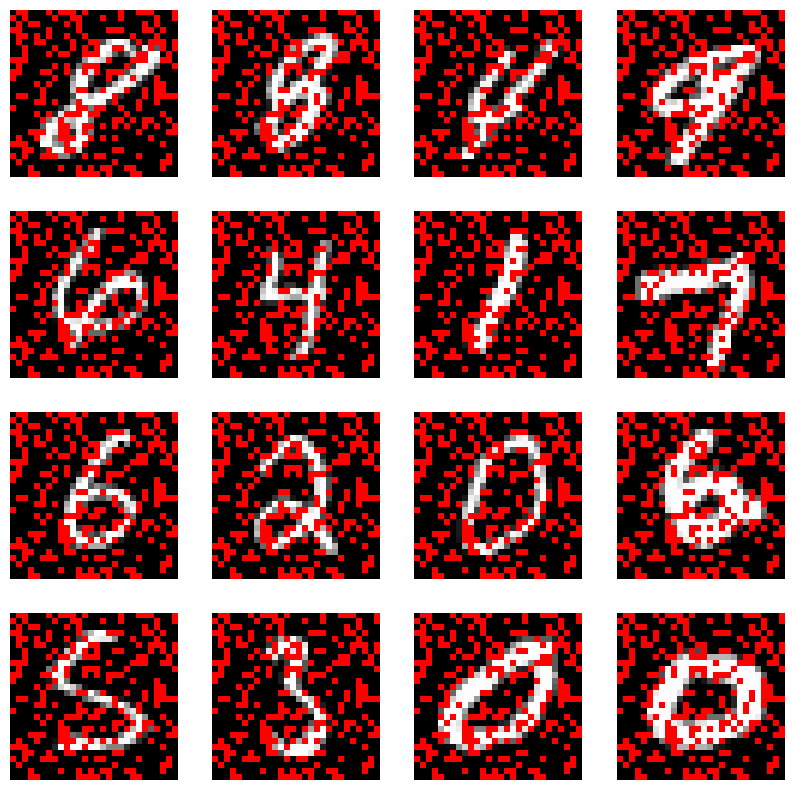

Iteration 0, loss = 2.6374
Checking accuracy on the val set
Got 1219 / 10000 correct (12.19%)

Iteration 200, loss = 0.7012
Checking accuracy on the val set
Got 8326 / 10000 correct (83.26%)

Iteration 400, loss = 0.5686
Checking accuracy on the val set
Got 8710 / 10000 correct (87.10%)

Iteration 600, loss = 0.5428
Checking accuracy on the val set
Got 8859 / 10000 correct (88.59%)

Iteration 0, loss = 0.5196
Checking accuracy on the val set
Got 8929 / 10000 correct (89.29%)

Iteration 200, loss = 0.4064
Checking accuracy on the val set
Got 9015 / 10000 correct (90.15%)

Iteration 400, loss = 0.3764
Checking accuracy on the val set
Got 9031 / 10000 correct (90.31%)

Iteration 600, loss = 0.3294
Checking accuracy on the val set
Got 9070 / 10000 correct (90.70%)

--------------------------------------------------------------------------------------------------------------------------------
8 iteration of pruning done Remaining Features: 66.70918367346938 %
-------------------------------

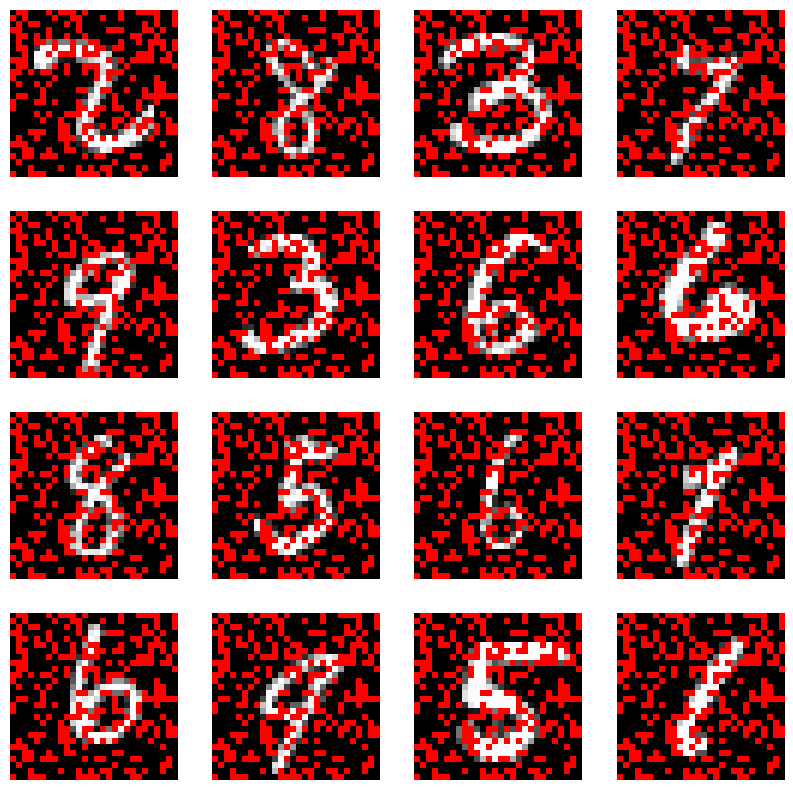

Iteration 0, loss = 2.6014
Checking accuracy on the val set
Got 1155 / 10000 correct (11.55%)

Iteration 200, loss = 0.8203
Checking accuracy on the val set
Got 8337 / 10000 correct (83.37%)

Iteration 400, loss = 0.7309
Checking accuracy on the val set
Got 8710 / 10000 correct (87.10%)

Iteration 600, loss = 0.5818
Checking accuracy on the val set
Got 8851 / 10000 correct (88.51%)

Iteration 0, loss = 0.3726
Checking accuracy on the val set
Got 8915 / 10000 correct (89.15%)

Iteration 200, loss = 0.4737
Checking accuracy on the val set
Got 8985 / 10000 correct (89.85%)

Iteration 400, loss = 0.5164
Checking accuracy on the val set
Got 9046 / 10000 correct (90.46%)

Iteration 600, loss = 0.3768
Checking accuracy on the val set
Got 9050 / 10000 correct (90.50%)

--------------------------------------------------------------------------------------------------------------------------------
9 iteration of pruning done Remaining Features: 63.392857142857146 %
------------------------------

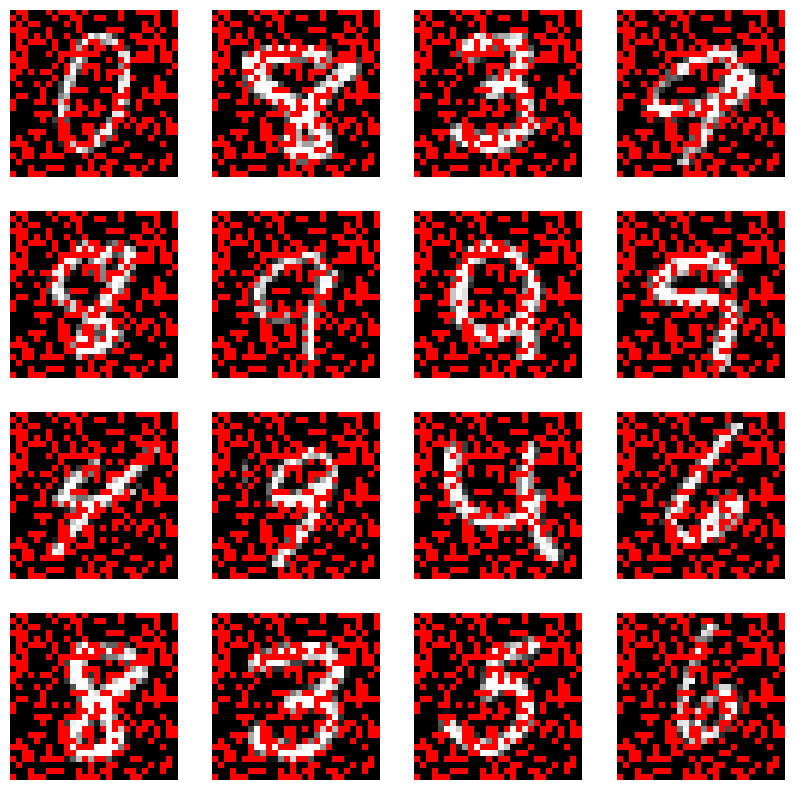

Iteration 0, loss = 2.6765
Checking accuracy on the val set
Got 1137 / 10000 correct (11.37%)

Iteration 200, loss = 0.8311
Checking accuracy on the val set
Got 8337 / 10000 correct (83.37%)

Iteration 400, loss = 0.6222
Checking accuracy on the val set
Got 8689 / 10000 correct (86.89%)

Iteration 600, loss = 0.5847
Checking accuracy on the val set
Got 8841 / 10000 correct (88.41%)

Iteration 0, loss = 0.5681
Checking accuracy on the val set
Got 8897 / 10000 correct (88.97%)

Iteration 200, loss = 0.3236
Checking accuracy on the val set
Got 8979 / 10000 correct (89.79%)

Iteration 400, loss = 0.3052
Checking accuracy on the val set
Got 9048 / 10000 correct (90.48%)

Iteration 600, loss = 0.3710
Checking accuracy on the val set
Got 9077 / 10000 correct (90.77%)

--------------------------------------------------------------------------------------------------------------------------------
10 iteration of pruning done Remaining Features: 60.33163265306122 %
------------------------------

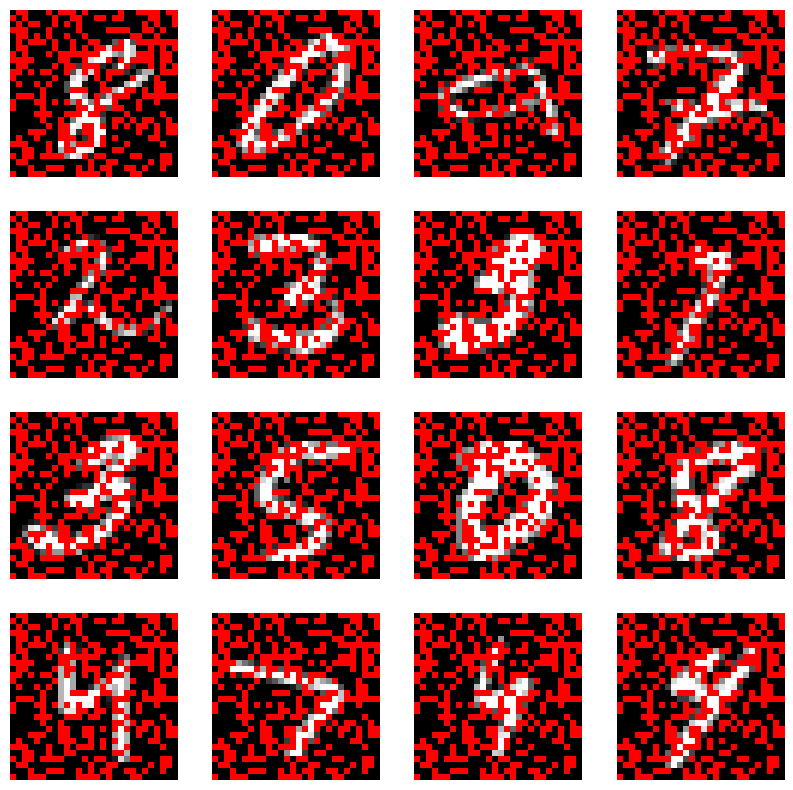

In [39]:
hidden_layer_size = 500
learning_rate = 1e-2

w1 = random_weight((28 * 28, hidden_layer_size))
w2 = random_weight((hidden_layer_size, 10))
mult = random_weight((1, 28 * 28))

initial_w1 = w1.clone().detach().requires_grad_(False)
initial_w2 = w2.clone().detach().requires_grad_(False)
initial_mult = mult.clone().detach().requires_grad_(False)

m1 = torch.ones((28 * 28, hidden_layer_size), dtype=dtype)
m2 = torch.ones((hidden_layer_size, 10), dtype=dtype)
m3 = torch.ones((28 * 28), dtype=dtype)

graph_info = []
tot_pruned = 0
    
for k in range(10):
    # train for 2 epochs
    acc = train(two_layer_fc, [w1, w2, mult, m1, m2, m3], learning_rate, print_every=200)
    acc = train(two_layer_fc, [w1, w2, mult, m1, m2, m3], learning_rate, print_every=200)
    
    # all = []

    # for i in range(w1.shape[0]):
    #     for j in range(w1.shape[1]):
    #         if m1[i][j] == 1:
    #             all.append(abs(w1[i][j].item()))
            
    # for i in range(w2.shape[0]):
    #     for j in range(w2.shape[1]):
    #         if m2[i][j] == 1:
    #             all.append(abs(w2[i][j].item()))
                
     
    # all = list(sorted(all))
    # thres = all[int(0.1 * len(all))]
    
    # with torch.no_grad():
    #     for i in range(m1.shape[0]):
    #         for j in range(m1.shape[1]):
    #             if abs(w1[i][j].item()) < thres:
    #                 m1[i][j] = 0 

                
    #     for i in range(m2.shape[0]):
    #         for j in range(m2.shape[1]):
    #             if abs(w2[i][j].item()) < thres:
    #                 m2[i][j] = 0
                
    # tot_remain = float((m1 == 1).sum() + (m2 == 1).sum())
    # tot = float(m1.shape[0] * m1.shape[1] + m2.shape[0] * m2.shape[1])

    # w1 = initial_w1.clone().detach().requires_grad_(True)
    # w2 = initial_w2.clone().detach().requires_grad_(True)
    
    # prune feature weights

    temp = []
    for i in range(28 * 28):
        if (m3[i] == 1):
            temp.append(abs(mult[0][i].item()))

    temp = list(sorted(temp))
    thres = temp[int(0.05 * len(temp))]

    for i in range(28 * 28):
        if abs(mult[0][i].item()) < thres and m3[i] == 1:
            m3[i] = 0
            tot_pruned += 1
            
    mult = initial_mult.clone().detach().requires_grad_(True)
    
    print('-' * 128)
    print(k+1, "iteration of pruning done", "Remaining Features:", 100 - tot_pruned / (28 * 28) * 100, "%")
    print('-' * 128)
    
    images, labels = next(iter(loader_train))

    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].permute(1, 2, 0))
        
        to_pil = T.ToPILImage()
        pil_image = to_pil(images[i])

        
        rgb_image = pil_image.convert("RGB")
        
        for i in range(rgb_image.size[0]):
            for j in range(rgb_image.size[1]):
                if m3[i * 28 + j].item() == 0:
                    rgb_image.putpixel((i, j), (255, 0, 0))
        
        ax.imshow(rgb_image)
        
        ax.axis('off')

    plt.show()
    
    # Reset the weights
    w1 = initial_w1.clone().detach().requires_grad_(True)
    w2 = initial_w2.clone().detach().requires_grad_(True)
    
    graph_info.append((100 - tot_pruned / (28 * 28) * 100, acc))



In [44]:
print("Accuracy with feature subset, original random weights")
print(train(two_layer_fc, [w1, w2, torch.ones((28 * 28), dtype=dtype, requires_grad=True), m1, m2, m3], learning_rate, print_every=100))



w1 = random_weight((28 * 28, hidden_layer_size))
w2 = random_weight((hidden_layer_size, 10))
mult = torch.ones((28 * 28), dtype=dtype)


print("Accuracy with feature subset, new random weights")
print(train(two_layer_fc, [w1, w2, torch.ones((28 * 28), dtype=dtype, requires_grad=True), m1, m2, m3], learning_rate, print_every=100))


Accuracy with feature subset, original random weights
Iteration 0, loss = 0.6459
Checking accuracy on the val set
Got 8767 / 10000 correct (87.67%)

Iteration 100, loss = 0.4938
Checking accuracy on the val set
Got 8821 / 10000 correct (88.21%)

Iteration 200, loss = 0.5691
Checking accuracy on the val set
Got 8850 / 10000 correct (88.50%)

Iteration 300, loss = 0.5682
Checking accuracy on the val set
Got 8887 / 10000 correct (88.87%)

Iteration 400, loss = 0.4339
Checking accuracy on the val set
Got 8901 / 10000 correct (89.01%)

Iteration 500, loss = 0.3154
Checking accuracy on the val set
Got 8926 / 10000 correct (89.26%)

Iteration 600, loss = 0.4638
Checking accuracy on the val set
Got 8947 / 10000 correct (89.47%)

Iteration 700, loss = 0.6299
Checking accuracy on the val set
Got 8970 / 10000 correct (89.70%)

0.897
Accuracy with feature subset, new random weights
Iteration 0, loss = 2.3079
Checking accuracy on the val set
Got 1174 / 10000 correct (11.74%)

Iteration 100, loss = 

[95.02551020408163, 90.3061224489796, 85.84183673469389, 81.63265306122449, 77.55102040816327, 73.72448979591837, 70.15306122448979, 66.70918367346938, 63.392857142857146, 60.33163265306122]
[0.9076, 0.9086, 0.9083, 0.9094, 0.909, 0.9085, 0.9095, 0.907, 0.905, 0.9077]


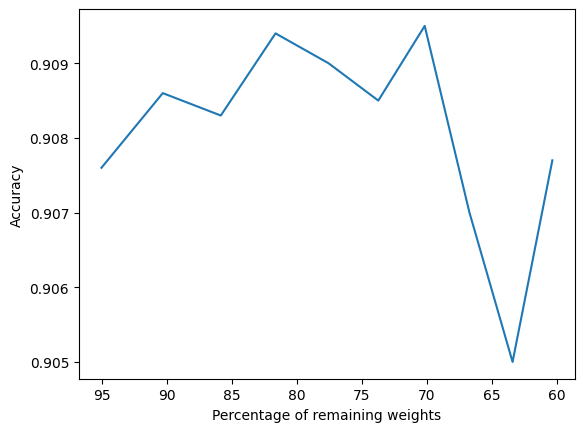

In [47]:
import matplotlib.pyplot as plt

# Extract x and y values from graph_info
x_values = [item[0] for item in graph_info]
y_values = [item[1] for item in graph_info]

print(x_values)
print(y_values)

# Plot the data
plt.plot(x_values, y_values)

# Reverse order of x-axis
plt.gca().invert_xaxis()

# find x axis labels more fine grained
plt.xticks(np.arange(60, 100, 5))

plt.xlabel('Percentage of remaining weights')
plt.ylabel('Accuracy')

# Show the plot
plt.show()
# Set x-axis scale to logarithmic with a multiplier coefficient of 0.4

